In [1]:
%load_ext autoreload
%autoreload
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.linalg as linalg
from scipy.stats import chisquare
from scipy.stats import linregress

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from BandPass import *
from fitFunctions import *
from tqdm import *

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 15

/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [717]:
dirName = "/home/jean/RomalisResearch/ncrescini/18-10-30 1/" # Directory with data
files = [f for f in os.listdir(dirName) if f.endswith('.txt')]
gHe = 20378.9
gNe = 2*np.pi*336.1
gRatio = gHe/gNe

ks1 = 3 # First file index
ks2 = 40 # Last file index
n_ave = 10 # Number of points to average over

dt = 1e-3*n_ave
Fs = 1/dt
D1Start = 50 # Start of first detection (currently only uses this)
D1EndTimes = [95] # End of first detection (currently only uses this)
D2Start = 200 # Start of second detection (currently doesn't use this)
D2EndTimes = [240] # End of second detection (currently doesn't use this)
curve_fit = True # Use curve_fit or scipy minimize
calcJac = True # Calculate jacobian by hand or extract errors/jacobian from fitter (curve_fit/scipy minimize)

n_subs_arr = np.arange(10, 75, 5) # Number of subsections to break the detection period into

In [718]:
bounds_fixfreq = ( ( -3, 3), (-1.5,1.5), (-1,1), (-1,1) ) # Bounds for fit if frequency is fixed, for scipy minimize
bounds = ( ( -3, 3), (-1.5,1.5), (0, 3), (-1,1), (-1,1), (10,20) ) # Bounds for fit if frequency is not fixed, for scipy minimize

bounds_fixfreq_cf = [ [ -3, -1.5, -1, -1 ], [ 3, 1.5, 1, 1 ] ] # Bounds for fit if frequency is fixed, for curve_fit
bounds_cf = [ [ -3, -1.5, 0, -1, -1, 10 ], [ 3, 1.5, 3, 1, 1, 20 ] ] # Bounds for fit if frequency is not fixed, for curve_fit

/home/jean/RomalisResearch/pulsed_fitter_current/BandPass.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  fftdata[1] = fft.fft(data_filt[1])/Lfilt
/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in sqrt


------------------- 10 -------------------
15.018615288949599 1.5564115152717748
15.018623501703015 1.5564101346487547
------------------- 15 -------------------
15.018615738273702 1.5564114397639728
15.018623843795481 1.5564065379841723
------------------- 20 -------------------
14.530810595524946 1.5564114091135475
15.01864069827266 1.5564168833681244
------------------- 25 -------------------
15.018615839124745 1.5564114776917304
15.018588380909236 1.5564124219637616
------------------- 30 -------------------
15.018615289318749 1.5564108773073526
15.018641150333023 1.5564065155410693
------------------- 35 -------------------
15.01861631209553 1.5564116068109803
15.018613968862626 1.5564120374384909
------------------- 40 -------------------
15.01861621065365 1.556412232303223
15.018614870011737 1.556402509210271
------------------- 45 -------------------
15.018616262812934 1.5564114525287822
15.018622805353287 1.5564181576679712
------------------- 50 -------------------
15.0186157

/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


------------------- 60 -------------------
15.018615624117206 1.556411878627278
15.018692176379963 1.5563999092671352
------------------- 65 -------------------
15.018619078505017 1.5564113268669828
15.01835987277934 1.5564444331526184
------------------- 70 -------------------
15.018613029055828 1.556412230030437
15.018632316290462 1.5564032586740117


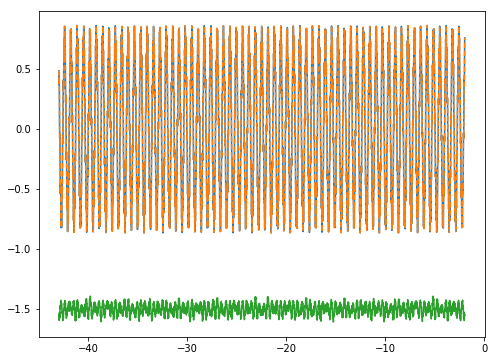

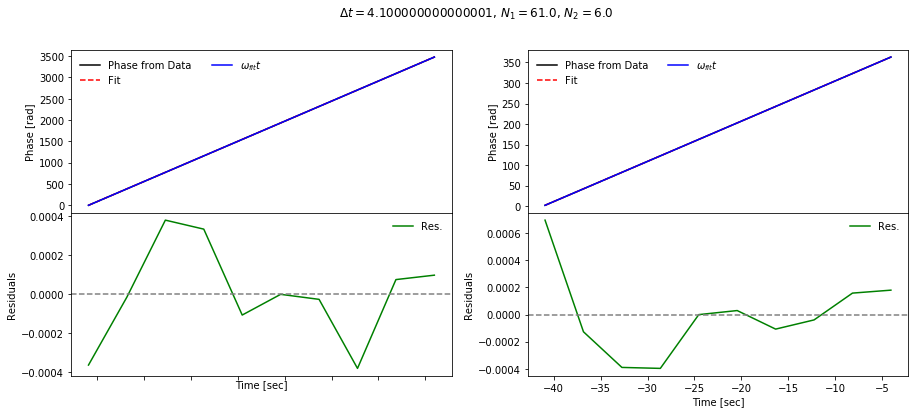

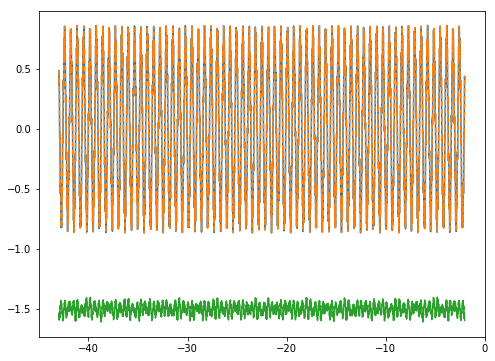

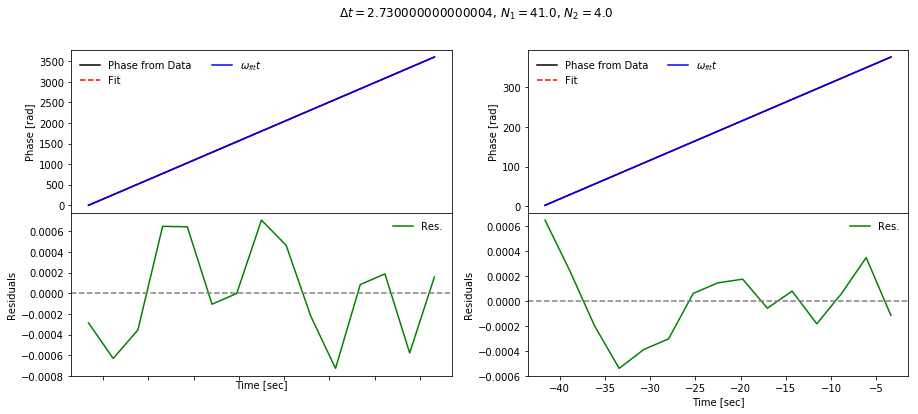

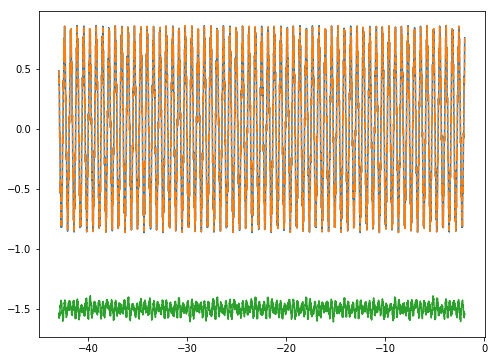

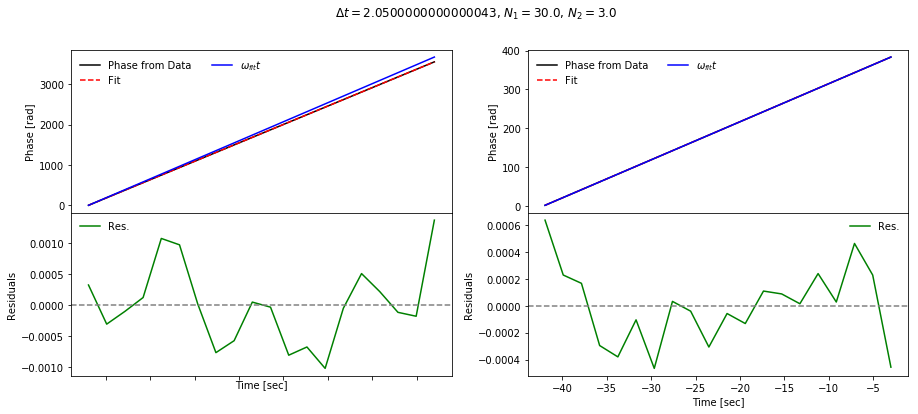

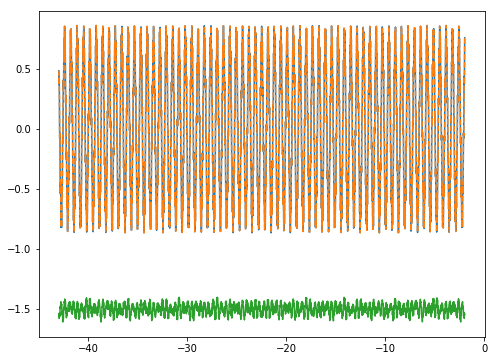

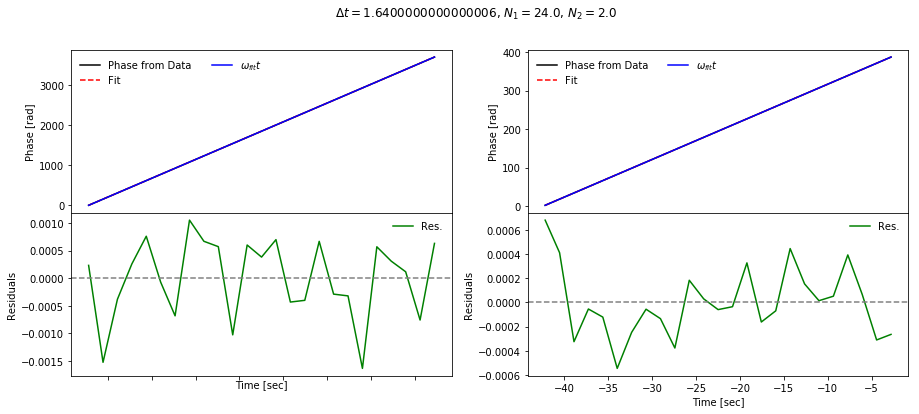

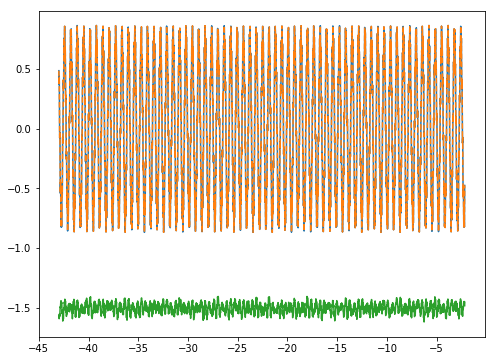

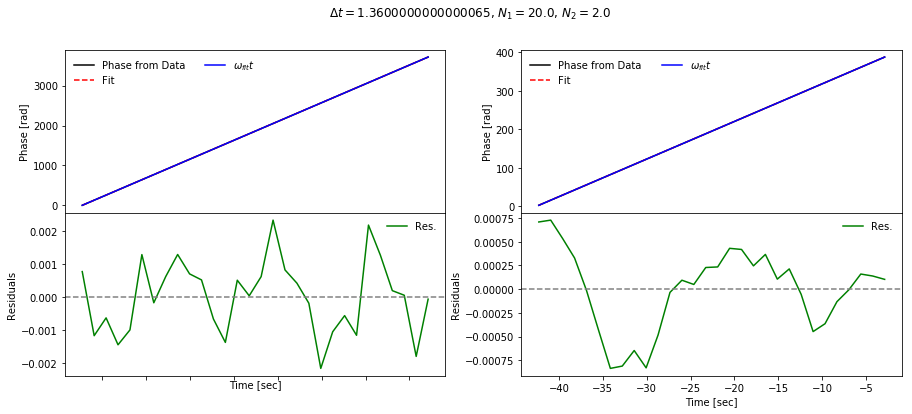

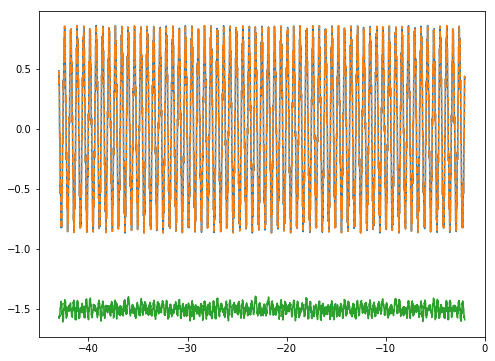

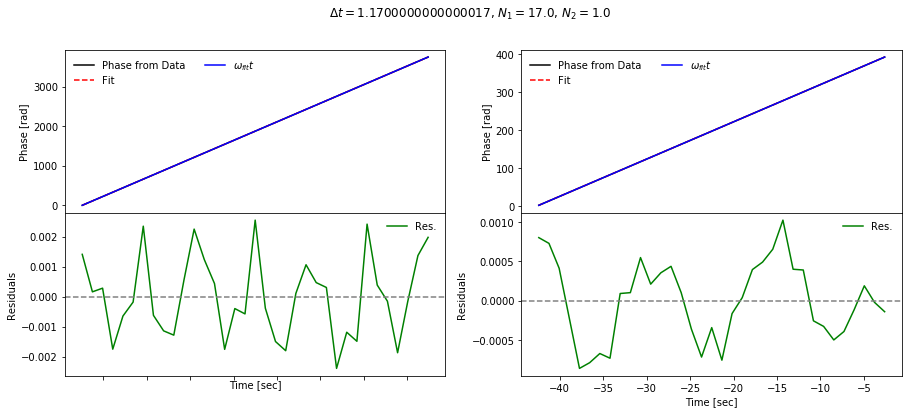

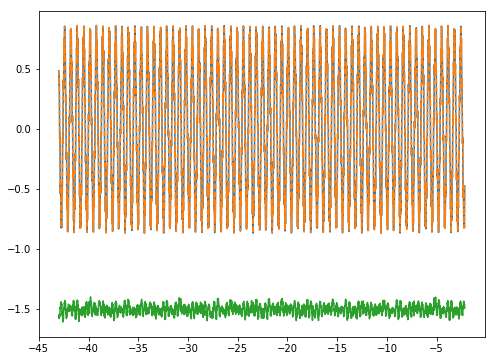

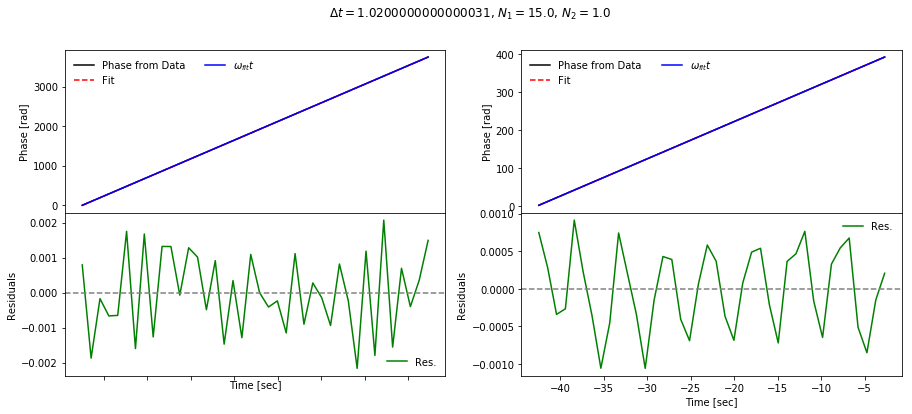

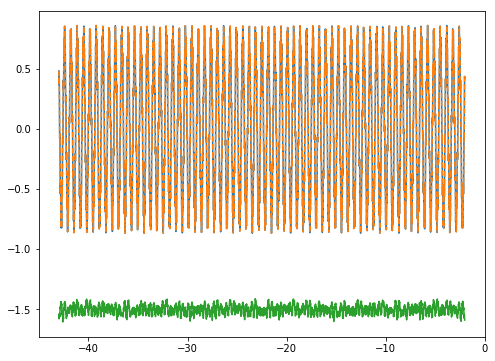

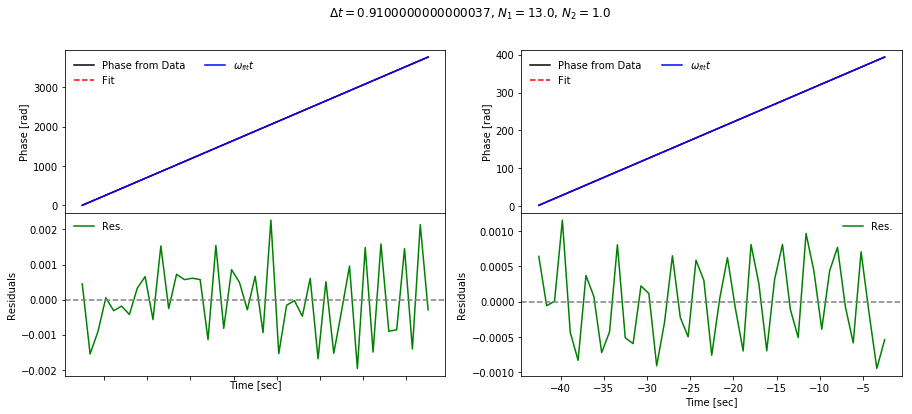

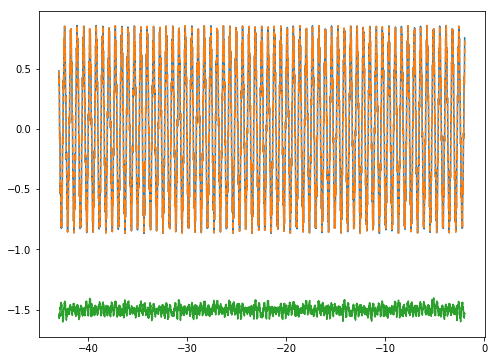

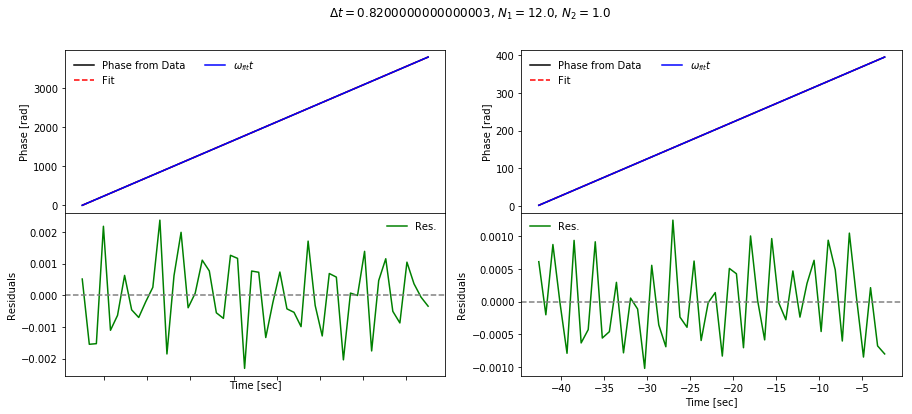

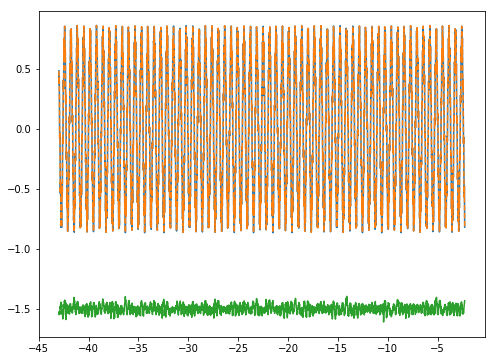

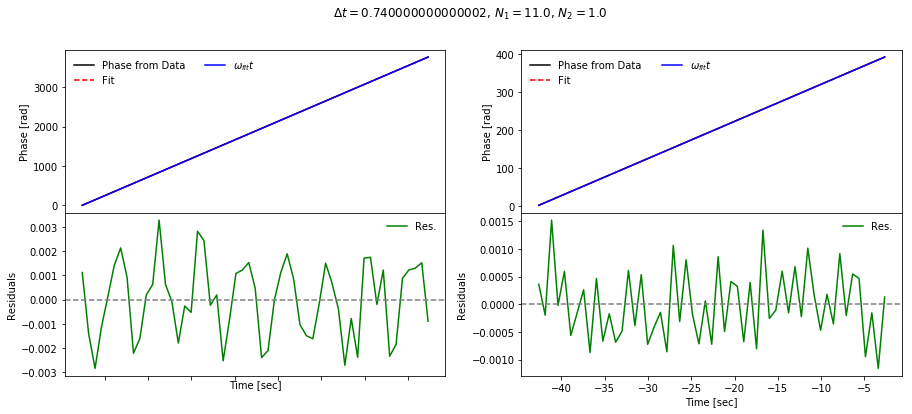

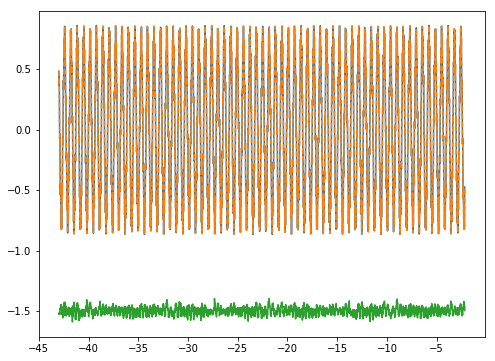

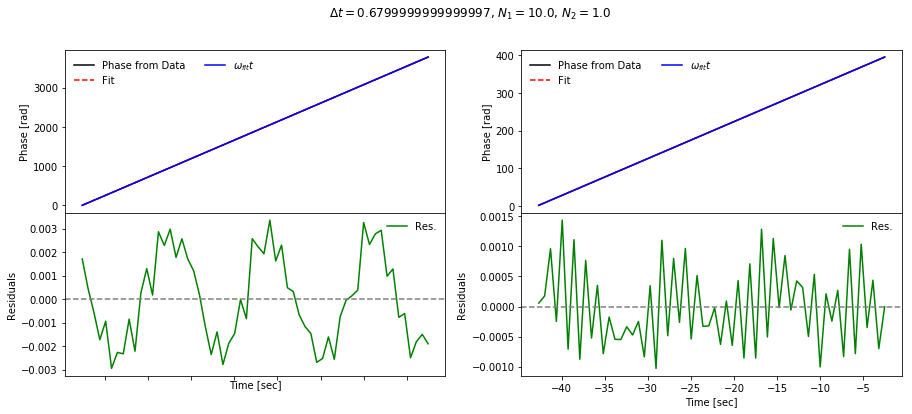

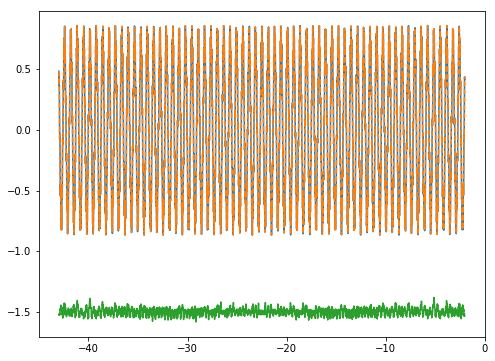

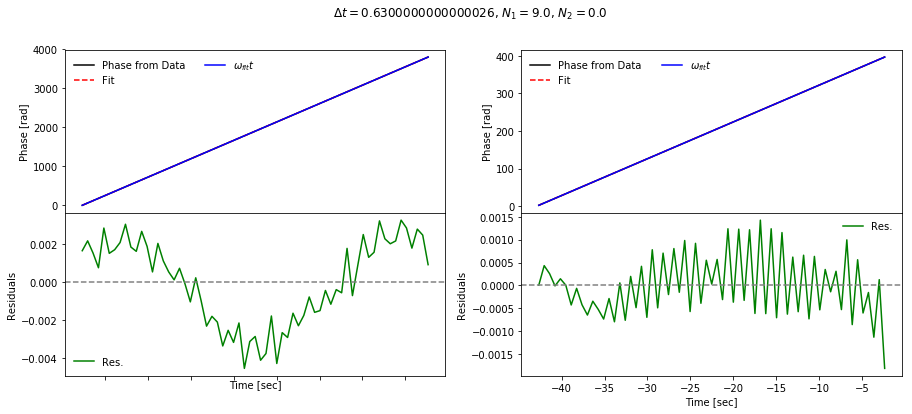

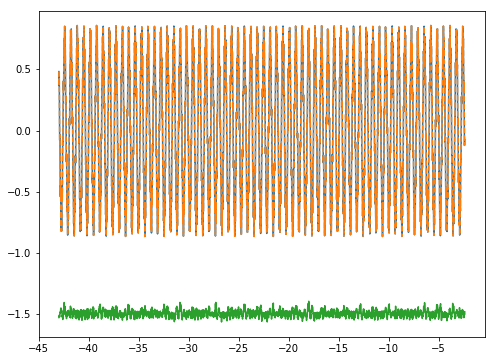

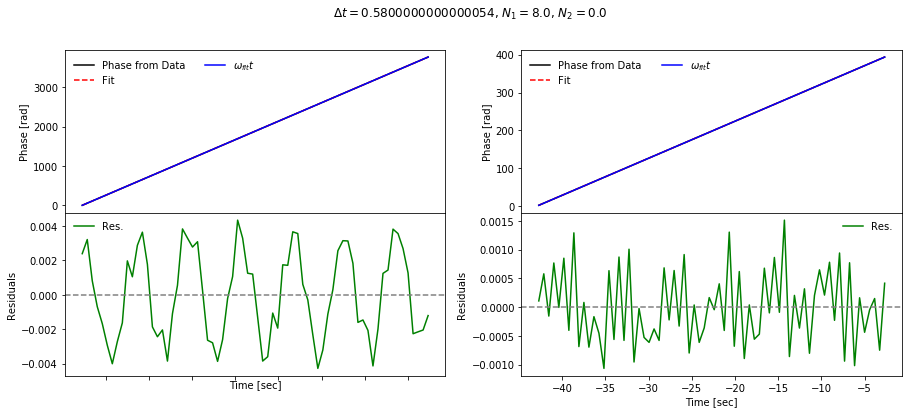

In [719]:
for n_subs in n_subs_arr:
    for k_ind in range(ks1, ks2+1):
        if "34" not in files[k_ind]: # DELETE LINE, right now set up to run over file 34 only
            continue                 # DELETE LINE
        paraOut = np.array([1.1, 1.1, 0.5, 0.5 ]) # Initial parameters for fit
        k = k_ind + ks1 - 1 # file number
        data = np.loadtxt(dirName+"/"+files[k_ind])
        data = data[:int(np.floor(len(data)/n_ave)*n_ave)]
        data = np.mean( data.reshape(-1, n_ave), axis=1 ) # Average data
        times = np.arange( 1, len(data)+1, 1 )*dt
        DStart = D1Start
        DEnd = D1EndTimes[np.mod(k_ind-1,len(D2EndTimes))]
        ind_DStart = np.argmin( np.abs(times - DStart) )+1 # Index of start time
        ind_DEnd = np.argmin( np.abs(times - DEnd) ) # Index of end time
        datafit = np.array([ times[ind_DStart:ind_DEnd] - times[ind_DEnd-1], data[ind_DStart:ind_DEnd] - np.mean(data[ind_DStart:ind_DEnd]) ])
        # Run fit a few times to get initial parameters
        paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope([para[0], para[1], 1.5554, para[2], para[3], 15.008], datafit[0])), [ paraOut[0], paraOut[1], paraOut[2], paraOut[3] ], method="SLSQP", bounds=bounds_fixfreq, options={'eps': 1e-12} ).x
        paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope(para, datafit[0])), [ paraOut[0], paraOut[1], 1.5554, paraOut[2], paraOut[3], 15.008 ], method="SLSQP", bounds=bounds, options={'eps': 1e-12} ).x
        datafit = BandPassFilter(datafit, dt, paraOut, 10, 2) # Bandpass filter
        paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope(para, datafit[0])), paraOut, method="SLSQP", bounds=bounds, options={'eps': 1e-12} ).x # Run fit again

        ## Partial Fitting
        NPoints = len(datafit[0])
        nPoints = int(np.floor(NPoints/n_subs))
        dataPar_x = datafit[0][:nPoints*n_subs]
        dataPar_y = datafit[1][:nPoints*n_subs]
        dataPar_x = np.reshape(dataPar_x, [n_subs, nPoints])
        dataPar_y = np.reshape(dataPar_y, [n_subs, nPoints])
        paraOut_arr = []
        errtout_arr = []
        errtout_arr2= []
        errchi2_arr = []
        datafit2 = []
        for i in range(n_subs):
            dataPar_x0 = dataPar_x[i] - min(dataPar_x[i]) # Set 0 to beginning of subsection of data
            # Run fit a few times with minimize to get good initial parameters
            fitResult = optimize.minimize( lambda para: least_sq(dataPar_y[i], fitSine2Slope([para[0], para[1], 1.5554, para[2], para[3], 15.008], dataPar_x0)), [ paraOut[0], paraOut[1], paraOut[3], paraOut[4]], method="SLSQP", bounds=bounds_fixfreq, options={'eps': 1e-12, 'maxiter': 10000} )
            fitResult = optimize.minimize( lambda para: least_sq(dataPar_y[i], fitSine2Slope(para, dataPar_x0)), [ fitResult.x[0], fitResult.x[1], 1.5554, fitResult.x[3], fitResult.x[3], 15.008], method="SLSQP", bounds=bounds, options={'eps': 1e-12, 'maxiter': 10000} )

            if curve_fit: # Run fit using curve fit
                fitResult = optimize.curve_fit( lambda xdata, *para: fitSine2Slope(para, xdata), dataPar_x0, dataPar_y[i], fitResult.x, bounds=bounds_cf, gtol=2.220446049250313e-16, ftol=2.220446049250313e-16, xtol=2.220446049250313e-16)
                #fitResult = optimize.least_squares( lambda xdata, *para: fitSine2Slope(para, xdata), dataPar_x[i], dataPar_y[i], x0=fitResult.x, bounds=bounds, gtol=2.220446049250313e-16, ftol=2.220446049250313e-16, xtol=2.220446049250313e-16)
                paraOut = fitResult[0]
                datafit2.extend(fitSine2Slope(paraOut, dataPar_x0))

                errtout = np.sqrt(np.diag(fitResult[1]))
            else: # Run fit using minimize
                fitResult = optimize.minimize( lambda para: least_sq(dataPar_y[i], fitSine2Slope(para, dataPar_x0)), fitResult.x, method="SLSQP", bounds=bounds, options={'eps': 1e-12} )
                paraOut = fitResult.x
                datafit2.extend(fitSine2Slope(paraOut, dataPar_x0))

            if calcJac or (not curve_fit): # Calculate jacobian by hand if desired
                if (not curve_fit) and (not calcJac): J = np.array([fitResult.jac])
                else: J = np.array([np.sum(np.array(Jacobian( paraOut, dataPar_x0 )).T, axis=0)])
                rechi2 = np.sum( (fitSine2Slope(paraOut, dataPar_x0) - dataPar_y[i])**2/(len(dataPar_x) - len(paraOut)))
                resigma = np.sqrt(rechi2)
                alpha = np.matmul( J.T, J )/resigma**2
                try:
                    erroralpha = np.linalg.inv(alpha.T)
                    errtout = np.sqrt(np.diag(erroralpha))
                except:
                    errtout = np.zeros(len(paraOut))

            paraOut_arr.append([ 
                np.sqrt(paraOut[0]**2 + paraOut[1]**2), paraOut[2], np.arctan2(paraOut[1], paraOut[0]), # Convert linearized parameters to normal
                np.sqrt(paraOut[3]**2 + paraOut[4]**2), paraOut[5], np.arctan2(paraOut[4], paraOut[3])
            ])
            errtout_arr.append([
                paraOut_arr[-1][0]**(-1) * np.sqrt( (errtout[0]/paraOut[0])**2 + (errtout[1]/paraOut[1])**2 ), # Convert linearized parameter errors to normal
                errtout[2], 
                np.abs(paraOut[0]*paraOut[1])/paraOut_arr[-1][0]**2 * np.sqrt( (errtout[0]/paraOut[0])**2 + (errtout[1]/paraOut[1])**2 ),
                paraOut_arr[-1][3]**(-1) * np.sqrt( (errtout[3]/paraOut[3])**2 + (errtout[4]/paraOut[4])**2 ), 
                errtout[5], 
                np.abs(paraOut[3]*paraOut[4])/paraOut_arr[-1][3]**2 * np.sqrt( (errtout[3]/paraOut[3])**2 + (errtout[4]/paraOut[4])**2 ),
            ])

    errtout_arr = np.array(errtout_arr)
    paraOut_arr = np.array(paraOut_arr)

    # Correcting phases by 2*pi*N
    n = 2*np.pi
    phi1_arr = paraOut_arr[:,5].copy() # phase 1
    phi2_arr = paraOut_arr[:,2].copy() # phase 2
    freq1 = 2*np.pi*np.mean(paraOut_arr[:,4])
    freq2 = 2*np.pi*np.mean(paraOut_arr[:,1])
    N1 = np.floor(freq1*(dataPar_x[1,0]-dataPar_x[0,0])/n) # Number of integer cycles for phase1 in 1 subsection of the data
    N2 = np.floor(freq2*(dataPar_x[1,0]-dataPar_x[0,0])/n) # Number of integer cycles for phase2 in 1 subsection of the data
    test_arr = []
    vald = -1 # How much to let N1, N2 vary by, minimum
    valu = 1 # How much to let N1, N2 vary by, maximum
    # Generate all possible combinations of number of 2*pi corrects for first 4 subsections
    for i1 in np.arange(vald,valu+1):
        for i2 in np.arange(vald,valu+1):
            for i3 in np.arange(vald,valu+1):
                test_arr.append(np.array([0, i1, i1+i2, i1+i2+i3 ]))

    l = 4
    resmin1 = np.inf
    resmin2 = np.inf
    # Find the number of 2*pis to add to the first 4 subsections to have the first four phases all be as linear as possible
    for it, test in enumerate(test_arr):
        phi1_arrT = (n*(test+np.arange(0,l)*N1) + phi1_arr[:l].copy()).copy()
        phi1_fit3 = linregress( np.mean(dataPar_x, axis=1)[:l], phi1_arrT )
        resmin = np.sum((phi1_arrT - (phi1_fit3[1] + np.mean(dataPar_x, axis=1)[:l]*phi1_fit3[0]))**2)
        if phi1_fit3[0] > 0 and resmin < resmin1 and np.abs((phi1_fit3[0]-freq1)/freq1) < 0.04:
            add1 = test+np.arange(0,l)*N1
            resmin1 = resmin
            fit1 = phi1_fit3
        phi2_arrT = (n*(test+np.arange(0,l)*N2) + phi2_arr[:l].copy())#.copy()
        phi2_fit3 = linregress( np.mean(dataPar_x, axis=1)[:l], phi2_arrT )
        resmin = np.sum((phi2_arrT - (phi2_fit3[1] + np.mean(dataPar_x, axis=1)[:l]*phi2_fit3[0]))**2)
        if phi2_fit3[0] > 0 and resmin < resmin2 and np.abs((phi2_fit3[0]-freq2)/freq2) < 0.04:
            add2 = test+np.arange(0,l)*N2
            resmin2 = resmin
            fit2 = phi2_fit3
    phi1_arr[:l] = n*add1 + phi1_arr[:l]
    phi2_arr[:l] = n*add2 + phi2_arr[:l]
    NCum1 = add1[-1]
    NCum2 = add2[-1]
    add1 = 0
    add2 = 0
    # Now correct the rest of the phases so they fall on the same line as the first four
    for i in range(len(phi1_arr)-l):
        ind = l+i
        resmin1 = np.inf
        resmin2 = np.inf
        for i0 in np.arange(vald,valu+1):
            phi1_arrT = phi1_arr[:ind+1].copy()
            phi1_arrT[-1] = phi1_arrT[-1] + n*(NCum1+N1+i0)
            phi1_fit = linregress( np.mean(dataPar_x, axis=1)[:ind+1], phi1_arrT )
            resmin = np.sum((phi1_arrT - (phi1_fit[1] + np.mean(dataPar_x, axis=1)[:ind+1]*phi1_fit[0]))**2)
            if phi1_fit[0] > 0 and resmin < resmin1 and np.abs((phi1_fit[0]-freq1)/freq1) < 0.04:
                add1 = N1+i0
                resmin1 = resmin

        for i0 in np.arange(vald,valu+1):
            phi2_arrT = phi2_arr[:ind+1].copy()
            phi2_arrT[-1] = phi2_arrT[-1] + n*(NCum2+N2+i0)
            phi2_fit = linregress( np.mean(dataPar_x, axis=1)[:ind+1], phi2_arrT )
            resmin = np.sum((phi2_arrT - (phi2_fit[1] + np.mean(dataPar_x, axis=1)[:ind+1]*phi2_fit[0]))**2)
            if phi2_fit[0] > 0 and resmin < resmin2 and np.abs((phi2_fit[0]-freq2)/freq2) < 0.04:
                add2 = N2+i0
                resmin2 = resmin

        phi1_arr[ind] = phi1_arr[ind] + n*(NCum1+add1)
        NCum1 = NCum1 + add1
        phi2_arr[ind] = phi2_arr[ind] + n*(NCum2+add2)
        NCum2 = NCum2 + add2

    # Make some plots
    mpl.rcParams['figure.figsize'] = [8.0, 6.0]
    plt.figure()
    plt.plot(dataPar_x.flatten(), (dataPar_y).flatten())
    plt.plot(dataPar_x.flatten(), datafit2, ls="--")
    plt.plot(dataPar_x.flatten(), 100*(datafit2-(dataPar_y).flatten())-1.5)
    mpl.rcParams['figure.figsize'] = [15.0, 6.0]
    phi1_fit = linregress( np.mean(dataPar_x, axis=1), phi1_arr )
    f, ax_arr = plt.subplots(2, 2)
    f.suptitle('$\Delta t = '+str(dataPar_x[1,0]-dataPar_x[0,0])+"$, $N_1="+str(N1)+"$, $N_2="+str(N2)+"$")
    ax_arr[0,0].plot( np.mean(dataPar_x, axis=1), phi1_arr, c="black", label="Phase from Data")
    ax_arr[0,0].plot( np.mean(dataPar_x, axis=1), phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0], c="red", ls="--", label="Fit")
    ax_arr[0,0].plot( np.mean(dataPar_x, axis=1), phi1_arr[0]+(np.mean(dataPar_x, axis=1)-np.mean(dataPar_x, axis=1)[0])*freq1, c="blue", label="$\omega_{fit}t$")
    ax_arr[1,0].plot( np.mean(dataPar_x, axis=1), (phi1_arr - (phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0])), c="green", label="Res.")
    ax_arr[1,0].axhline(0, ls="--", c="grey")
    ax_arr[0,0].legend(frameon=False, ncol=2 )
    ax_arr[1,0].legend(frameon=False, ncol=2 )
    ax_arr[1,0].set_xlabel("Time [sec]")
    ax_arr[0,0].set_ylabel("Phase [rad]")
    ax_arr[1,0].set_ylabel("Residuals")
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    phi2_fit = linregress( np.mean(dataPar_x, axis=1), phi2_arr )
    ax_arr[0,1].plot( np.mean(dataPar_x, axis=1), phi2_arr, c="black", label="Phase from Data")
    ax_arr[0,1].plot( np.mean(dataPar_x, axis=1), phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0], c="red", ls="--", label="Fit")
    ax_arr[0,1].plot( np.mean(dataPar_x, axis=1), phi2_arr[0]+(np.mean(dataPar_x, axis=1)-np.mean(dataPar_x, axis=1)[0])*freq2, c="blue", label="$\omega_{fit}t$")
    ax_arr[1,1].plot( np.mean(dataPar_x, axis=1), (phi2_arr - (phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0])), c="green", label="Res.")
    ax_arr[1,1].axhline(0, ls="--", c="grey")
    ax_arr[0,1].legend(frameon=False, ncol=2 )
    ax_arr[1,1].legend(frameon=False, ncol=2 )
    ax_arr[1,1].set_xlabel("Time [sec]")
    ax_arr[0,1].set_ylabel("Phase [rad]")
    ax_arr[1,1].set_ylabel("Residuals")
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    print('-------------------', n_subs, '-------------------')
    print(phi1_fit[0]/2/np.pi, phi2_fit[0]/2/np.pi)
    print(freq1/2/np.pi, freq2/2/np.pi)